In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img


import os
os.listdir('/kaggle/input/gtsrb-german-traffic-sign')

['Meta',
 'meta',
 'Meta.csv',
 'Train.csv',
 'Test.csv',
 'Test',
 'test',
 'Train',
 'train']

## problem and data explanation

##### In the world of Artificial Intelligence and advancement in technologies, many researchers and big companies like Tesla, Uber, Google, Mercedes-Benz, Toyota, Ford, Audi, etc are working on autonomous vehicles and self-driving cars. So, for achieving accuracy in this technology, the vehicles should be able to interpret traffic signs and make decisions accordingly.

##### The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. the properties are:
##### 1- Single-image, multi-class classification problem
##### 2- More than 40 classes
##### 3- More than 50,000 images in total
##### 4- Large, lifelike database

##### here we classify the signs using deep learning(CNN) algorithm. we create the datasets using imageDataGenerator and then made the pictures ready for process.
##### after making the model, we compiled it with adam optimizer and 'categorical_crossentropy' loss function.
##### after fitting this model during seven epochs (batch_size = 128), we got 99% accuracy on training/validation sets and 98% accuracy on the test set.

## loading dataset into train/test dataFrames

In [6]:
df_train = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv')
df_test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')

## shape of the dataFrames

In [7]:
print('the train shape is: ', df_train.shape)
print('the test shape is: ', df_test.shape)

the train shape is:  (39209, 8)
the test shape is:  (12630, 8)


## check if there are duplicated rows

In [8]:
df_train.duplicated().sum()

0

## check if there is a null row

In [9]:
df_train.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

## information about the training dataFrame

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


## see the fifth rows of the df_train

In [11]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


## delete some columns (remains just Path and ClassId)

In [12]:
df_train.drop(columns=['Width','Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], inplace=True)
df_test.drop(columns=['Width','Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], inplace=True)

## change the type of the ClassId datas to str

In [13]:
df_train['ClassId'] = df_train['ClassId'].astype(str)
df_test['ClassId'] = df_test['ClassId'].astype(str)

## split to train and val dataFrames

In [14]:
import sklearn
from sklearn.model_selection import train_test_split
df_train_target, df_val= train_test_split(df_train, test_size=0.2, stratify=df_train['ClassId'], random_state=42)
df_train = df_train_target.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

## see some examples of the traffic signs with its label

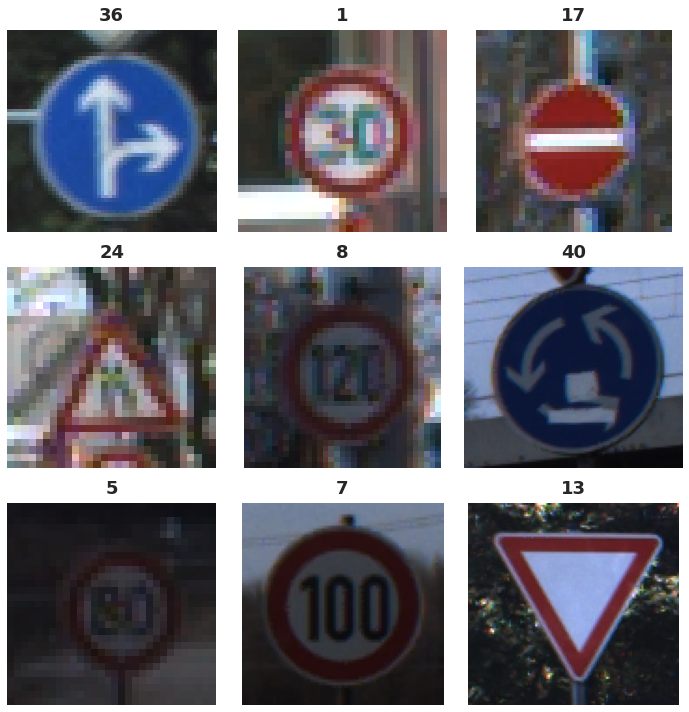

In [15]:
train_image_path = '/kaggle/input/gtsrb-german-traffic-sign/'

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    Img = plt.imread(train_image_path + df_train_target.iloc[i,1])
    plt.imshow(Img)
    plt.title(str(df_train_target.iloc[i,0]))
    plt.axis("off")

## see the dispersion of the labels in dataset

In [16]:
print(df_train.groupby('ClassId').size())

ClassId
0      168
1     1776
10    1608
11    1056
12    1680
13    1728
14     624
15     504
16     336
17     888
18     960
19     168
2     1800
20     288
21     264
22     312
23     408
24     216
25    1200
26     480
27     192
28     432
29     216
3     1128
30     360
31     624
32     192
33     551
34     336
35     960
36     312
37     168
38    1656
39     240
4     1584
40     288
41     192
42     192
5     1488
6      336
7     1152
8     1128
9     1176
dtype: int64


### it is the preprocessing part. first we apply data augmentation on the training dataset with ImageDataGenerator, then we rescale and resize the traffic signs pic, at the end we create the target dataset.

In [17]:

train_datagen = image.ImageDataGenerator(
    rotation_range = 15,
    rescale = 1.0/255.0,
    zoom_range = 0.2,
)

val_datagen = image.ImageDataGenerator(rescale = 1.0/255.0)


# make dataset

batch_size=128
IMG_SIZE=224

train_generator = train_datagen.flow_from_dataframe(df_train_target, 
                                  directory = train_image_path,
                                  x_col = 'Path',
                                  y_col = 'ClassId',
                                  target_size = (IMG_SIZE, IMG_SIZE),
                                  class_mode = 'categorical',
                                  batch_size = batch_size)

val_generator = val_datagen.flow_from_dataframe(df_val, 
                                  directory = train_image_path,
                                  x_col = 'Path',
                                  y_col = 'ClassId',
                                  target_size = (IMG_SIZE, IMG_SIZE),
                                  class_mode = 'categorical',
                                  batch_size = batch_size)

Found 31367 validated image filenames belonging to 43 classes.
Found 7842 validated image filenames belonging to 43 classes.


## see an example of preprocessing picture

Found 1 validated image filenames belonging to 1 classes.


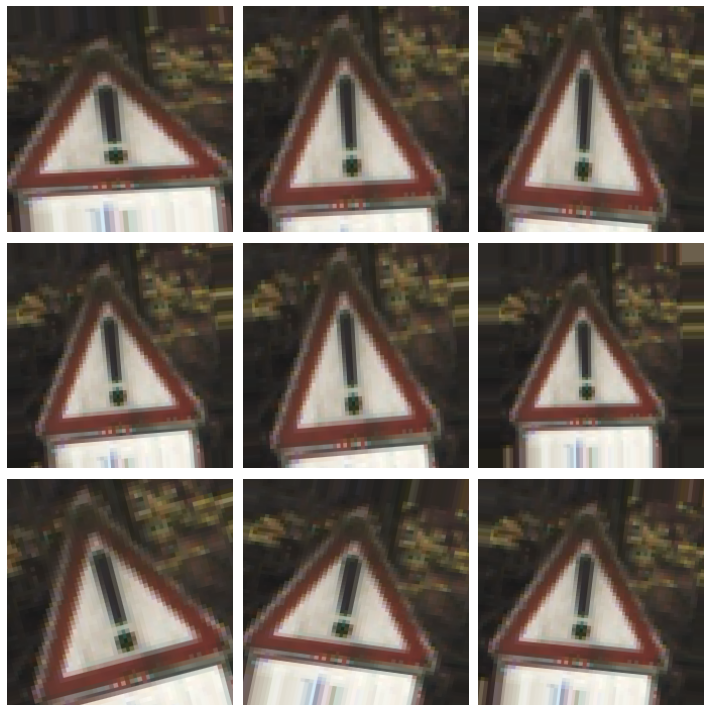

In [18]:

ex = df_train.sample(1)

ex_generator = train_datagen.flow_from_dataframe(ex,
                                  directory = train_image_path,
                                  x_col = 'Path',
                                  y_col = 'ClassId',
                                  target_size = (224, 224),
                                  class_mode = 'categorical')


plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in ex_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis("off")
        break
plt.tight_layout()
plt.show()

## create the model using keras.Sequential

In [28]:

model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,3)))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(43, activation = 'softmax'))

## compile the model

In [29]:
model.compile(
optimizer=tf.keras.optimizers.Adam(1e-3),
loss="categorical_crossentropy",
metrics=["accuracy"],
)

## summary of the model

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 32)     

## callbacks (saving model + EarlyStopping)

In [31]:
Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

## fitting the model

In [32]:
epochs = 7

history = model.fit(
    train_generator, epochs=epochs, callbacks=callbacks,
    validation_data= val_generator,
)

Epoch 1/7
246/246 [==============================] - 377s 2s/step - loss: 2.5476 - accuracy: 0.3884 - val_loss: 2.7324 - val_accuracy: 0.3231
Epoch 2/7
246/246 [==============================] - 374s 2s/step - loss: 0.1881 - accuracy: 0.9423 - val_loss: 0.1050 - val_accuracy: 0.9712
Epoch 3/7
246/246 [==============================] - 383s 2s/step - loss: 0.0679 - accuracy: 0.9811 - val_loss: 0.0291 - val_accuracy: 0.9918
Epoch 4/7
246/246 [==============================] - 443s 2s/step - loss: 0.0447 - accuracy: 0.9870 - val_loss: 0.0258 - val_accuracy: 0.9932
Epoch 5/7
246/246 [==============================] - 433s 2s/step - loss: 0.0363 - accuracy: 0.9886 - val_loss: 0.0231 - val_accuracy: 0.9950
Epoch 6/7
246/246 [==============================] - 392s 2s/step - loss: 0.0373 - accuracy: 0.9892 - val_loss: 0.0109 - val_accuracy: 0.9976
Epoch 7/7
246/246 [==============================] - 387s 2s/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0156 - val_accuracy: 0.9949


## visualize the fitting

<AxesSubplot:>

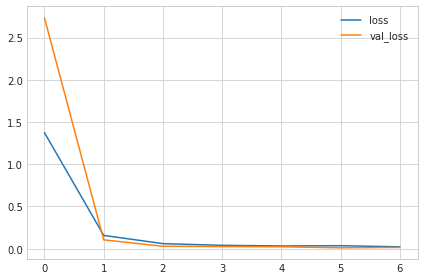

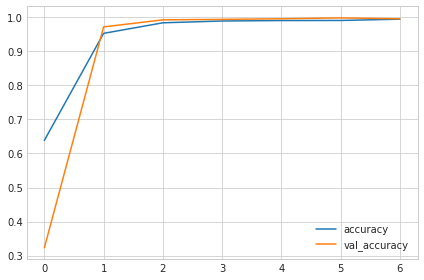

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

##### we can see the model is just right(no overfitting/ no underfitting)

## prepare the test dataset

In [36]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory = train_image_path,
    x_col = 'Path',
    y_col = 'ClassId',
    class_mode = 'categorical',
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False
)

Found 12630 validated image filenames belonging to 43 classes.


## save the model

In [37]:
model.load_weights('save_model.h5')

## evaluate the model on the test set

In [38]:
model.evaluate(test_generator)

99/99 [==============================] - 87s 885ms/step - loss: 0.0625 - accuracy: 0.9825


[0.06249462440609932, 0.9825019836425781]

#### we can see the loss function amount is 0.062 and the accuracy is 98.2%

# NICE